In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

import kaggle_functions as kaggle
import importlib
importlib.reload(kaggle);

model_number = 'basic_stacking'

In [2]:
# Create datasets
train_dataset, valid_dataset, valid_labels = kaggle.load_train_as_dataset()
x_test_real = kaggle.load_test_set()

In [5]:
filepaths_to_load = {
    'model6/VGG_6_79': 0.79,
    'model7/DeeperVGG_4_79': 0.79,
    'model7/DeeperVGG_6_84': 0.84,
    'model8/VGGRes_3_79': 0.79,
    'model9/DeeperVGG2_2_84': 0.84,
    'model10/WideResNet_3_80': 0.80,
    'model10/WideResNet_5_84': 0.84,
    'model10/WideResNet_8_83': 0.83,
}

valid_predictions = np.zeros((2378, 11, len(filepaths_to_load)))
test_predictions = np.zeros((17831, 11, len(filepaths_to_load)))

In [6]:
models_succesfully_seen = 0
for index, filepath in enumerate(filepaths_to_load):
    if index >= models_succesfully_seen:
        print(f'Loading and predicting {filepath}')
        model = keras.models.load_model(f'models/{filepath}')
        softmax_valid_pred = np.array(tf.nn.softmax(model.predict(valid_dataset.batch(128))))
        softmax_test_pred = np.array(tf.nn.softmax(model.predict(x_test_real)))
        
        valid_predictions[:, :, index] = softmax_valid_pred
        test_predictions[:, :, index] = softmax_test_pred
        models_succesfully_seen += 1

Loading and predicting model6/VGG_6_79
Loading and predicting model7/DeeperVGG_4_79
Loading and predicting model7/DeeperVGG_6_84
Loading and predicting model8/VGGRes_3_79
Loading and predicting model9/DeeperVGG2_2_84
Loading and predicting model10/WideResNet_3_80
Loading and predicting model10/WideResNet_5_84
Loading and predicting model10/WideResNet_8_83


In [14]:
# Determine best weighting factors (possibly overfitting since we are using valid set for selection)
for probability_power in range(1, 4):
    for accuracy_power in range(1, 16, 2):
        print(f'Prob power:{probability_power}, accuracy power: {accuracy_power}')
        adapted_pred = np.power(valid_predictions, probability_power)
        for index, accuracy in enumerate(filepaths_to_load.values()):
            adapted_pred[:, :, index] *= accuracy**accuracy_power
        adapted_pred = np.sum(adapted_pred, axis=2)
        adapted_pred = np.argmax(adapted_pred, axis=1)
        kaggle.print_accuracy(valid_labels, adapted_pred)

Prob power:1, accuracy power: 1
Accuracy: 0.8768
Prob power:1, accuracy power: 3
Accuracy: 0.8776
Prob power:1, accuracy power: 5
Accuracy: 0.8789
Prob power:1, accuracy power: 7
Accuracy: 0.8806
Prob power:1, accuracy power: 9
Accuracy: 0.8797
Prob power:1, accuracy power: 11
Accuracy: 0.8802
Prob power:1, accuracy power: 13
Accuracy: 0.8797
Prob power:1, accuracy power: 15
Accuracy: 0.8797
Prob power:2, accuracy power: 1
Accuracy: 0.8751
Prob power:2, accuracy power: 3
Accuracy: 0.8776
Prob power:2, accuracy power: 5
Accuracy: 0.8785
Prob power:2, accuracy power: 7
Accuracy: 0.8789
Prob power:2, accuracy power: 9
Accuracy: 0.8793
Prob power:2, accuracy power: 11
Accuracy: 0.8806
Prob power:2, accuracy power: 13
Accuracy: 0.8802
Prob power:2, accuracy power: 15
Accuracy: 0.8797
Prob power:3, accuracy power: 1
Accuracy: 0.8768
Prob power:3, accuracy power: 3
Accuracy: 0.8789
Prob power:3, accuracy power: 5
Accuracy: 0.8806
Prob power:3, accuracy power: 7
Accuracy: 0.8797
Prob power:3, 

Accuracy: 0.8802


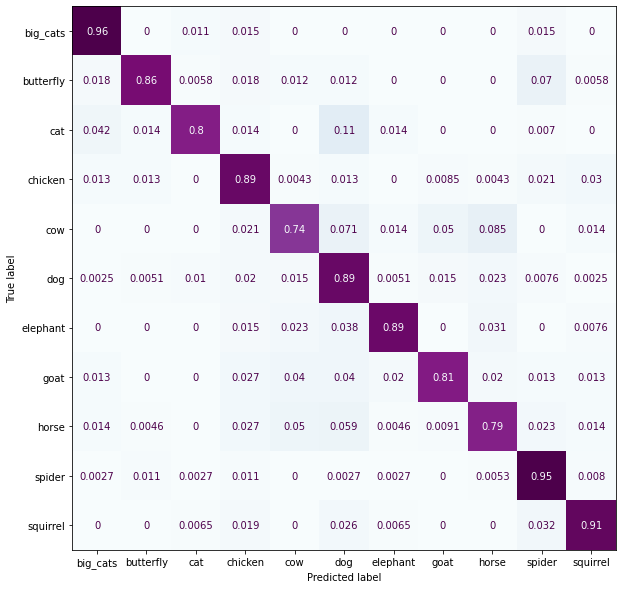

In [15]:
# Evaluate performance on validation set
modified_valid_predictions = np.power(valid_predictions, 1)
for index, accuracy in enumerate(filepaths_to_load.values()):
    modified_valid_predictions[:, :, index] *= accuracy**11
modified_valid_predictions = np.sum(modified_valid_predictions, axis=2)
modified_valid_predictions = np.argmax(modified_valid_predictions, axis=1)

kaggle.print_accuracy(valid_labels, modified_valid_predictions)
kaggle.plot_confusion_matrix(valid_labels, modified_valid_predictions)

In [8]:
# Predict labels for kaggle
modified_test_predictions = np.power(test_predictions, 1)
for index, accuracy in enumerate(filepaths_to_load.values()):
    modified_test_predictions[:, :, index] *= accuracy**13
modified_test_predictions = np.sum(modified_test_predictions, axis=2)
modified_test_predictions = np.argmax(modified_test_predictions, axis=1)

kaggle.save_test_pred('models/basic_stacking/basic_stacking_test7.csv', modified_test_predictions)